In [1]:
# importing the modules 
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
from time import time
import dask.dataframe as dd
import pickle
from tqdm import tqdm
from IPython.display import display 
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import datetime as dt

In [2]:
# credits : https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
def load_df(csv_path, nrows=None):
    # define a list of JSON columns to decode
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={
                         # converting dtype from string to json
                         column: json.loads for column in JSON_COLUMNS}, 
                     # treating 'fullVisitorId' as string
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)

    for column in JSON_COLUMNS:
        # json_normalize will return flattened normalized semi-structured JSON data
        column_as_df = json_normalize(df[column])
        # extracting column names in "column.subcolumn" format, eg. "totals.hits"
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns] 
        # drop original encoded json columns and merge new json parsed columns
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True) 
        
    print("Loaded {0}. Shape: {1}".format(os.path.basename(csv_path), df.shape))
    
    return df

In [5]:
# checking dataframe sizes
print(f'train shape: {train_df.shape} \ntest shape: {test_df.shape}')

train shape: (1708337, 60) 
test shape: (401589, 59)


## Saving loaded dataframes in a pickle file

In [28]:
# with open('../test_v2.pickle','wb') as f:
#     pickle.dump(test_df, f)

In [29]:
# with open('../train_v2.pickle','wb') as f:
#     pickle.dump(train_df, f)

## Load dataframes from pickle files

In [2]:
start = time()
with open('../train_v2.pickle','rb') as f:
    train_df = pickle.load(f)

with open('../test_v2.pickle','rb') as f:
    test_df = pickle.load(f)
end = time()
print(f'Time for loading pickle files: {(end-start)/60} mins')

Time for loading pickle files: 4.7204925139745075 mins


In [8]:
# checking loaded pickle files
print(f'train shape: {train_df.shape} \ntest shape: {test_df.shape}')

train shape: (1708337, 60) 
test shape: (401589, 59)


In [5]:
# checking loaded pickle files
train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# checking loaded pickle files
test_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1526099341,2,1526099341,Chrome,...,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,1526064483,166,1526064483,Chrome,...,(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,3461808543879602873,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,1526067157,2,1526067157,Chrome,...,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,975129477712150630,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",Not Socially Engaged,1526107551,4,1526107551,Chrome,...,(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,8381672768065729990,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1526060254,1,1526060254,Internet Explorer,...,organic,(not provided),(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN


* creating a smaller df to test code faster because original train df is very large in size

In [9]:
train_subset = train_df[:10000].copy(deep=True)
train_subset.head(2)

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,(not set),google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN


# 1. Data Preprocessing

### 1.1 Remove columns having single values throughout as they are not useful for predicting the target variable.

In [5]:
# nunique() gives the count of unqiues values of each column
train_subset.nunique()

channelGrouping                                         7
customDimensions                                        6
date                                                    4
fullVisitorId                                        9210
hits                                                 9809
socialEngagementType                                    1
visitId                                              9812
visitNumber                                            73
visitStartTime                                       9813
device.browser                                         23
device.browserVersion                                   1
device.browserSize                                      1
device.operatingSystem                                 15
device.operatingSystemVersion                           1
device.isMobile                                         2
device.mobileDeviceBranding                             1
device.mobileDeviceModel                                1
device.mobileI

In [3]:
start = time()
# make a list of all column names
column_list = train_df.columns.to_list()
for column in column_list:
    # dropping columns having single value across all rows
    if train_df[column].nunique() == 1:
        del train_df[column]

end = time()

print(f'Time taken: {(end-start)/60} mins')
print(f'After dropping single valued columns df size is: {train_df.shape}')
train_df.head(2)

Time taken: 1.8660331209500631 mins
After dropping single valued columns df size is: (1708337, 36)


,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,(not set),google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN


In [4]:
%%time
train_df.nunique()

CPU times: user 1min 45s, sys: 96.8 ms, total: 1min 45s
Wall time: 1min 45s


channelGrouping                                       8
customDimensions                                      6
date                                                638
fullVisitorId                                   1323730
hits                                            1338924
visitId                                         1665802
visitNumber                                         457
visitStartTime                                  1667423
device.browser                                      129
device.operatingSystem                               24
device.isMobile                                       2
device.deviceCategory                                 3
geoNetwork.continent                                  6
geoNetwork.subContinent                              23
geoNetwork.country                                  228
geoNetwork.region                                   483
geoNetwork.metro                                    123
geoNetwork.city                                 

In [5]:
# SAVING RAW DATA FOR EDA
with open('../train_eda.pickle', 'wb') as f:
    pickle.dump(train_df, f)

# 2. Feature Importance

In [61]:
train_df.dtypes

channelGrouping                                 object
customDimensions                                object
date                                             int64
fullVisitorId                                   object
hits                                            object
visitId                                          int64
visitNumber                                      int64
visitStartTime                                   int64
device.browser                                  object
device.operatingSystem                          object
device.isMobile                                   bool
device.deviceCategory                           object
geoNetwork.continent                            object
geoNetwork.subContinent                         object
geoNetwork.country                              object
geoNetwork.region                               object
geoNetwork.metro                                object
geoNetwork.city                                 object
geoNetwork

In [62]:
train_df["date"] = pd.to_datetime(train_df["date"], format="%Y%m%d")

In [63]:
numeric_feat = ['visitNumber','visitStartTime','totals.hits','totals.pageviews','totals.timeOnSite',
                'totals.transactions','totals.totalTransactionRevenue','totals.transactionRevenue']

for col in numeric_feat:
    train_df[col].fillna(0,inplace=True)
#     train_df[col] = train_df[col].astype('float')
    
    test_df[col].fillna(0,inplace=True)
#     test_df[col] = test_df[col].astype('float')
    

In [12]:
train_df.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'visitId', 'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions',
       'totals.transactionRevenue', 'totals.totalTransactionRevenue',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType'],
      dtype='object')

In [64]:
# useless features
train_df.drop(['customDimensions', 'hits'], axis=1, inplace=True)

In [65]:
# object cols
object_cols = list(train_df.select_dtypes(include=['object', 'bool']).columns)
# object_cols = [obj for obj in object_cols if obj not in ('customDimensions', 'hits')]
object_cols

['channelGrouping',
 'fullVisitorId',
 'device.browser',
 'device.operatingSystem',
 'device.isMobile',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'totals.sessionQualityDim',
 'totals.timeOnSite',
 'totals.transactions',
 'totals.transactionRevenue',
 'totals.totalTransactionRevenue',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.referralPath',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.adNetworkType']

In [66]:
%%time
# source : https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
for feature in object_cols:
    # intitalizing label encoder object
    label_encoder = preprocessing.LabelEncoder()
    # fit with list of variables in that feature
    label_encoder.fit(list(train_df[feature].values.astype('str')))
    # transforming that feature
    train_df[feature] = label_encoder.transform(list(train_df[feature].values.astype('str')))
    print(f"Label encoding for {feature} completed.")

Label encoding for channelGrouping completed.
Label encoding for fullVisitorId completed.
Label encoding for device.browser completed.
Label encoding for device.operatingSystem completed.
Label encoding for device.isMobile completed.
Label encoding for device.deviceCategory completed.
Label encoding for geoNetwork.continent completed.
Label encoding for geoNetwork.subContinent completed.
Label encoding for geoNetwork.country completed.
Label encoding for geoNetwork.region completed.
Label encoding for geoNetwork.metro completed.
Label encoding for geoNetwork.city completed.
Label encoding for geoNetwork.networkDomain completed.
Label encoding for totals.sessionQualityDim completed.
Label encoding for totals.timeOnSite completed.
Label encoding for totals.transactions completed.
Label encoding for totals.transactionRevenue completed.
Label encoding for totals.totalTransactionRevenue completed.
Label encoding for trafficSource.campaign completed.
Label encoding for trafficSource.source c

In [67]:
train_df.dtypes

channelGrouping                                          int64
date                                            datetime64[ns]
fullVisitorId                                            int64
visitId                                                  int64
visitNumber                                              int64
visitStartTime                                           int64
device.browser                                           int64
device.operatingSystem                                   int64
device.isMobile                                          int64
device.deviceCategory                                    int64
geoNetwork.continent                                     int64
geoNetwork.subContinent                                  int64
geoNetwork.country                                       int64
geoNetwork.region                                        int64
geoNetwork.metro                                         int64
geoNetwork.city                                        

In [73]:
# split train and target variables
target = train_df['totals.transactionRevenue']
train = train_df.drop(['totals.transactions','totals.transactionRevenue','totals.totalTransactionRevenue'], axis=1)
train['date']=train['date'].map(dt.datetime.toordinal)

In [11]:
# rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
#        max_features='auto',n_estimators=1000, n_jobs=-1,random_state=44, verbose=1)
rfr = RandomForestRegressor(bootstrap=True, criterion='mse',
       max_features='auto',n_estimators=500, n_jobs=-1,random_state=44, verbose=1)

# Train the regressor model
rfr.fit(train, target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.2min finished


RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=44, verbose=1)

In [87]:
# SAVING FILES AS PICKLE

# with open('../rfr.pickle', 'wb') as f:
#     pickle.dump(rfr, f)
# with open('../train_encoded.pickle', 'wb') as f:
#     pickle.dump(train, f)
# with open('../target_encoded.pickle', 'wb') as f:
#     pickle.dump(target, f)

In [69]:
# READ PICKLE FILES
with open('../rfr.pickle', 'rb') as f:
    rfr = pickle.load(f)
with open('../train_encoded.pickle', 'rb') as f:
    train = pickle.load(f)    
with open('../target_encoded.pickle', 'rb') as f:
    target = pickle.load(f)

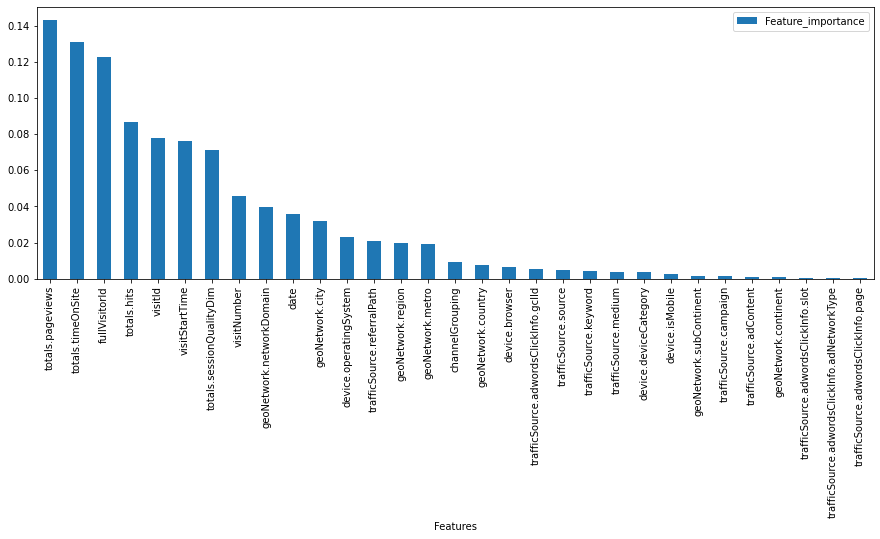

In [70]:
# importance of each attribute
feature_imp_df = pd.DataFrame({'Features':train.columns.values, 'Feature_importance':rfr.feature_importances_})
feature_imp_df.sort_values(by=['Feature_importance'], ascending = False).plot(kind='bar', x='Features', y='Feature_importance', figsize=(15,5));

* **Observations:-**
    1. Pageviews and timeOnSite are 2 most important features according to the Random Forest model.
    2. We will not consider VisitorId and visitId even though the model gives it high importance because individually they will not help to generalise the model.
    


# 3. EDA
References used:
* https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
* https://www.kaggle.com/kabure/exploring-the-consumer-patterns-ml-pipeline

* **READING RAW DATA FOR EDA**

In [2]:
%%time
with open('../train_eda.pickle','rb') as f:
    train_df = pickle.load(f)

CPU times: user 19.2 s, sys: 22.9 s, total: 42.1 s
Wall time: 3min 42s


In [11]:
# global plotting configurations
params = {'axes.titlesize':'32',
          'xtick.labelsize':'20',
          'ytick.labelsize':'20'}
matplotlib.rcParams.update(params)

## 3.1 Target variable

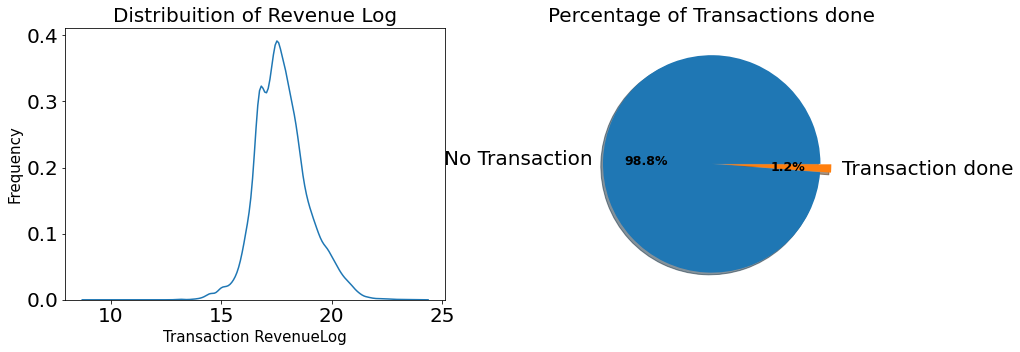

In [5]:
# converting to type 'float'
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')

# seting the figure size of our plots
fig = plt.figure(figsize=(15,5))
# creating a subplot grid of 1 x 2
plt.subplot(1,2,1)
# plotting log distribution of transactionRevenue
ax = sns.kdeplot(np.log1p(train_df["totals.transactionRevenue"]))
#seting the xlabel and size of font
ax.set_xlabel('Transaction RevenueLog', fontsize=15)
# seting the ylabel and size of font
ax.set_ylabel('Frequency', fontsize=15)
# seting the title and size of font
ax.set_title("Distribuition of Revenue Log", fontsize=20)

# setting the second plot of our grid
plt.subplot(1,2,2)
# grouping by transactionRevenue according to each customer
tmp = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
# setting all customers having transactionRevenue > 0 to 1
tmp.loc[tmp['totals.transactionRevenue']>0] = 1
# custom labels:- 0:No Transaction  1:Transaction done
mylabels = ['No Transaction', 'Transaction done']
# credits: https://stackoverflow.com/questions/57062322/python-how-to-change-autopct-text-to-white-and-bold-in-a-pie-chart
_, _, autopcts = plt.pie(tmp['totals.transactionRevenue'].value_counts(), explode=[0,0.1], labels=mylabels, autopct='%1.1f%%',
        shadow=True)
plt.setp(autopcts, **{'color':'black', 'weight':'bold', 'fontsize':12.5})
#seting the title and size of font
plt.title("Percentage of Transactions done", fontsize=20)

plt.show()

* **Observations:**
    1. We can see that the natural log of target variable(TransactionRevenue) follows gaussian distribution, which is good because we don't need to deal with unbalanced-target-problem.
    2. From the pie chart we can see that from all our customers only **1.2% have completed a transaction.**

## 2.2 Date plots

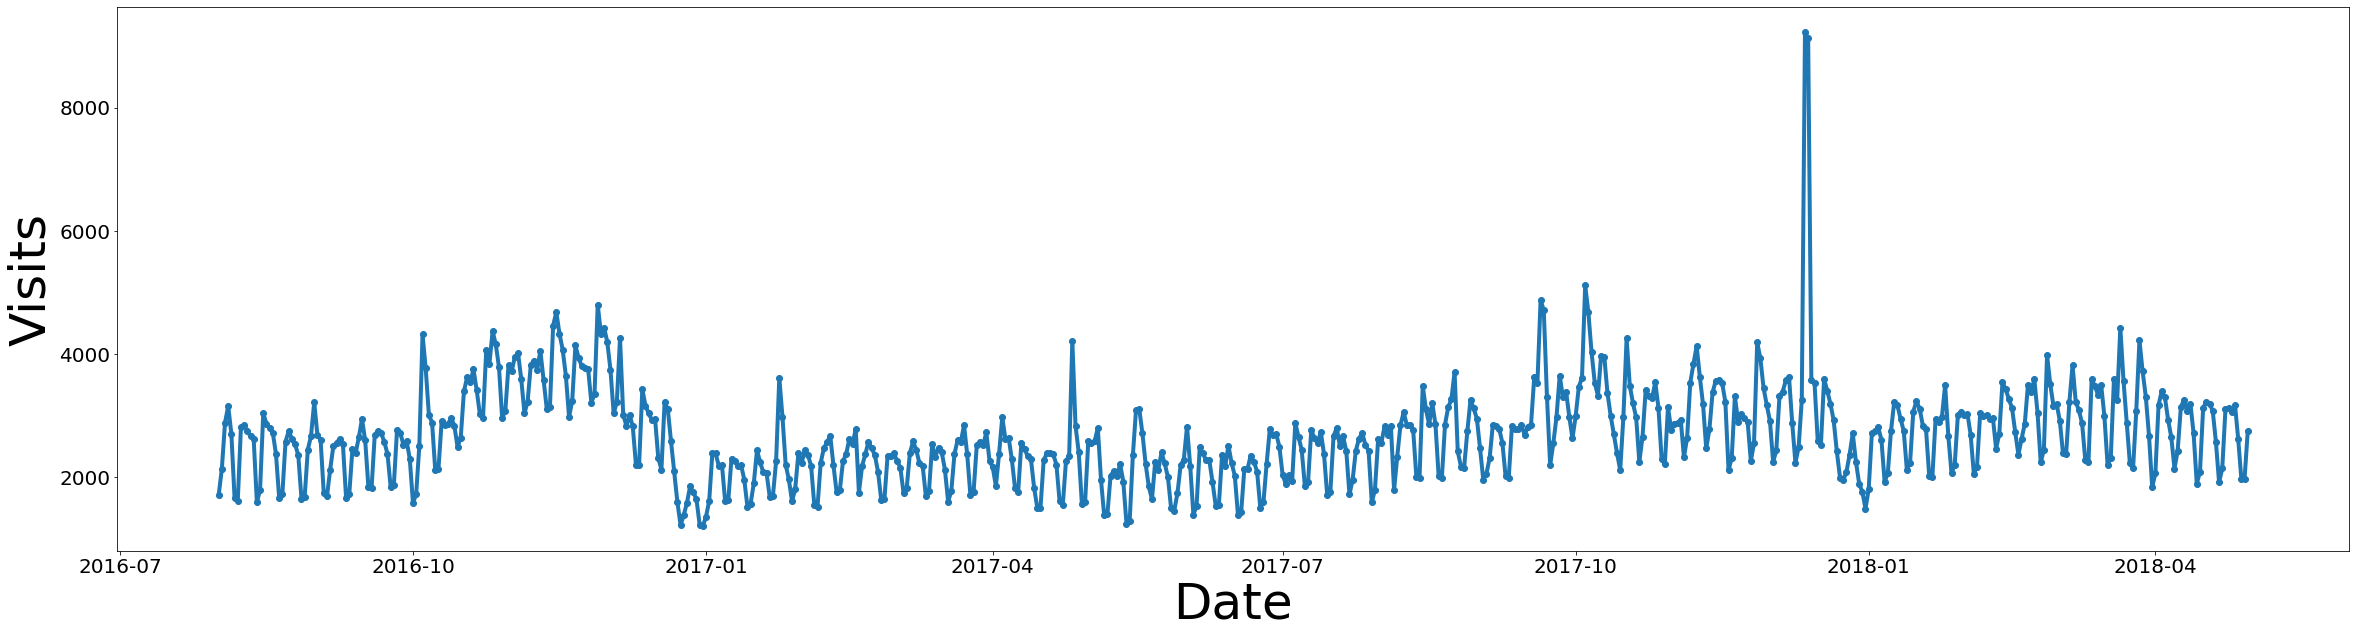

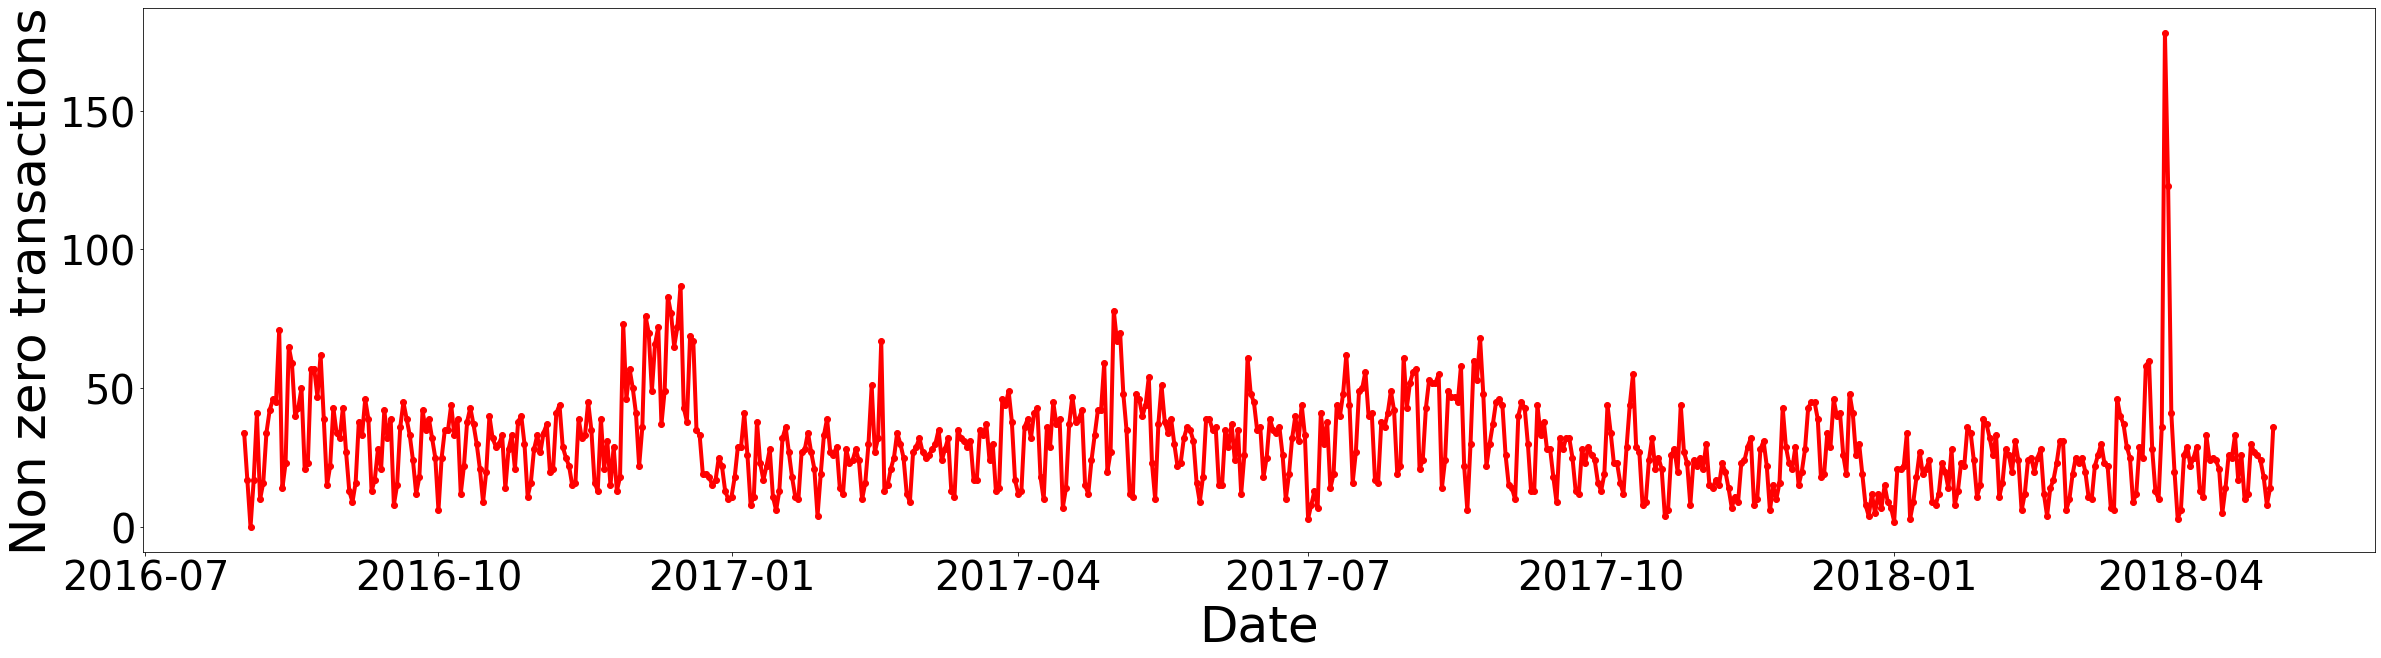

In [5]:
# converting to datetime format
train_df["date"] = pd.to_datetime(train_df["date"], format="%Y%m%d")
# groupby using .agg(['size', 'count']) where size includes NaN values, count does not.
tmp = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count']).reset_index()
# adding column names
tmp.columns = ["date", "count", "count of non-zero revenue"]

# plot for no.of visits in each date :
plt.figure(figsize=(40,10))
plt.plot_date(x = tmp['date'], y = tmp['count'],linestyle='solid',linewidth=4)
# set labels and labelsize for x,y axes
plt.xlabel('Date',fontsize=50)
plt.ylabel('Visits',fontsize=50)
# set size of ticks on x,y axes
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40) 

# plot for transcation revenue in each date :

plt.figure(figsize=(40,10))
plt.plot_date(x = tmp['date'], y = tmp['count of non-zero revenue'],linestyle='solid',color='red', linewidth=4)
# set labels and labelsize for x,y axes
plt.xlabel('Date',fontsize=50)
plt.ylabel('Non zero transactions',fontsize=50)
# set size of ticks on x,y axes
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)

plt.show()

* **Observations:**
    1. No of visits increased in Dec 2017 drastically, but no of transactions didn't.
    2. No of transactions suddenly incresed in March 2018

# pageviews

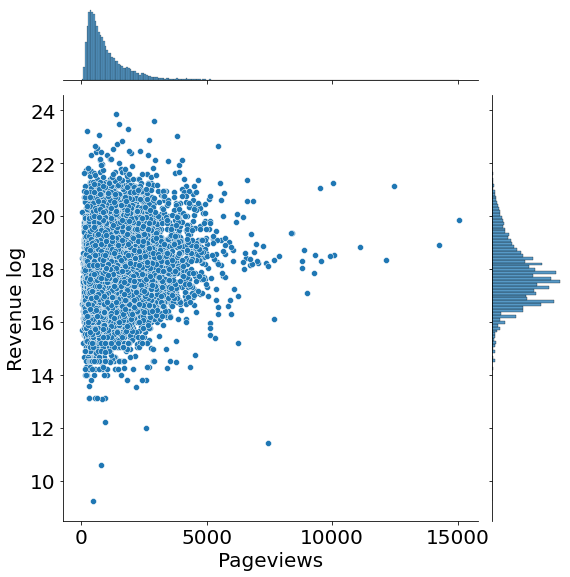

In [72]:
train_df['totals.pageviews'] = train_df['totals.pageviews'].astype('float32')
train_df['revenue_log'] = np.log1p(train_df['totals.transactionRevenue'])
# train_df['pageviews_log'] = np.log1p(train_df['totals.pageviews'])
jplot = sns.jointplot(x='totals.pageviews', y='revenue_log', data=train_df, height=8, dropna=True)
jplot.set_axis_labels('Pageviews', 'Revenue log', fontsize=20)
plt.show()

In [67]:
train_df['totals.timeOnSite'].describe()

count    834043.000000
mean        253.648499
std         473.665497
min           1.000000
25%          31.000000
50%          80.000000
75%         244.000000
max       19017.000000
Name: totals.timeOnSite, dtype: float64

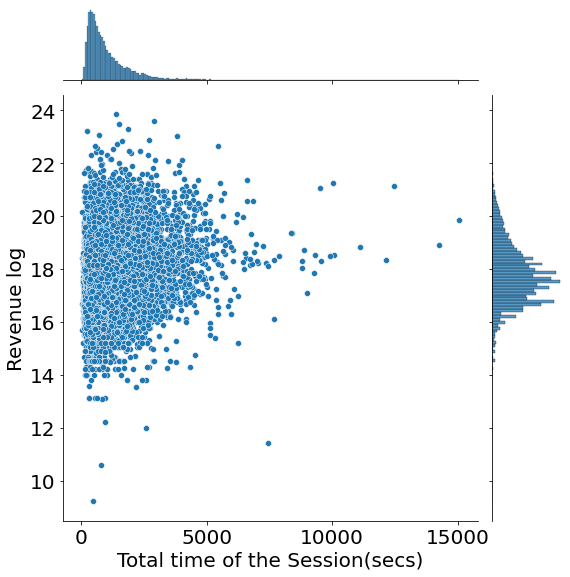

In [69]:
train_df['totals.timeOnSite'] = train_df['totals.timeOnSite'].astype('float32')
jplot = sns.jointplot(x='totals.timeOnSite', y='revenue_log', data=train_df, height=8, dropna=True)
jplot.set_axis_labels('Total time of the Session(secs)', 'Revenue log', fontsize=20)
plt.show()

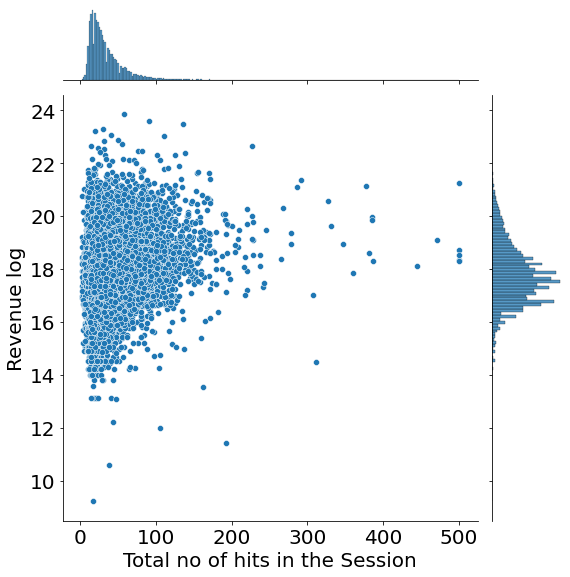

In [70]:
train_df['totals.hits'] = train_df['totals.hits'].astype('float32')
jplot = sns.jointplot(x='totals.hits', y='revenue_log', data=train_df, height=8, dropna=True)
jplot.set_axis_labels('Total no of hits in the Session', 'Revenue log', fontsize=20)
plt.show()

## 2.4 Channel Grouping analysis

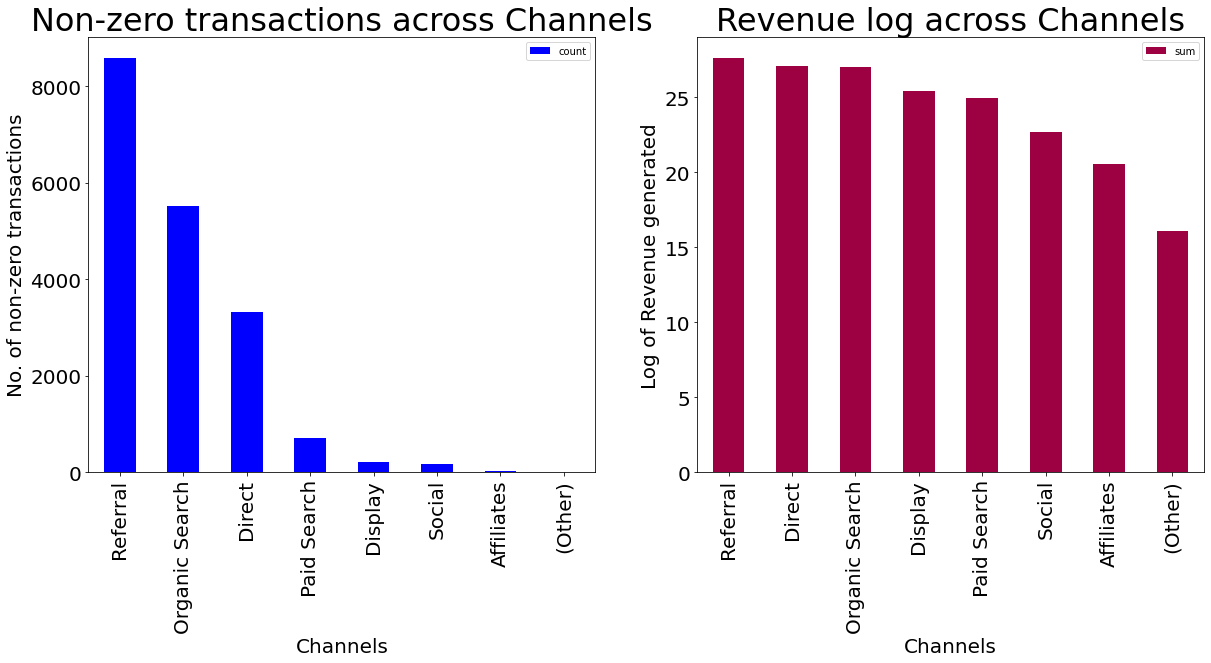

In [8]:
# creating a subplot grid of 1 x 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

# ------no of user visits across each channel------
# grouping by channels according to each customer
tmp = train_df.groupby('channelGrouping')['totals.transactionRevenue'].agg(['count','sum']).reset_index()
# plotting the bar graph
tmp.sort_values('count', ascending=False).plot(kind='bar', x='channelGrouping', y='count', \
                                               colormap='winter', ax=axes[0], \
                                               title = 'Non-zero transactions across Channels')
# setting labels for x,y axes
axes[0].set_xlabel("Channels", fontsize=20)
axes[0].set_ylabel("No. of non-zero transactions", fontsize=20)

# ------log of revenue generated by each channel-------
tmp['sum'] = np.log1p(tmp['sum'])
# plotting the bar graph
tmp.sort_values('sum', ascending=False).plot(kind='bar', x='channelGrouping', y='sum', \
                                             title="Revenue log across Channels", colormap='Spectral', ax=axes[1])
# setting labels for x,y axes
axes[1].set_xlabel("Channels", fontsize=20)
axes[1].set_ylabel("Log of Revenue generated", fontsize=20)

# display plots
plt.show()

* **Observations:**
    1. Most visits come from Organic search and it also has high revenue generation.
    2. Revenue from referrals is also high but visits from it is low, so marketing teams can work to engage more users through referral channels

## 2.4 Web browser analysis 

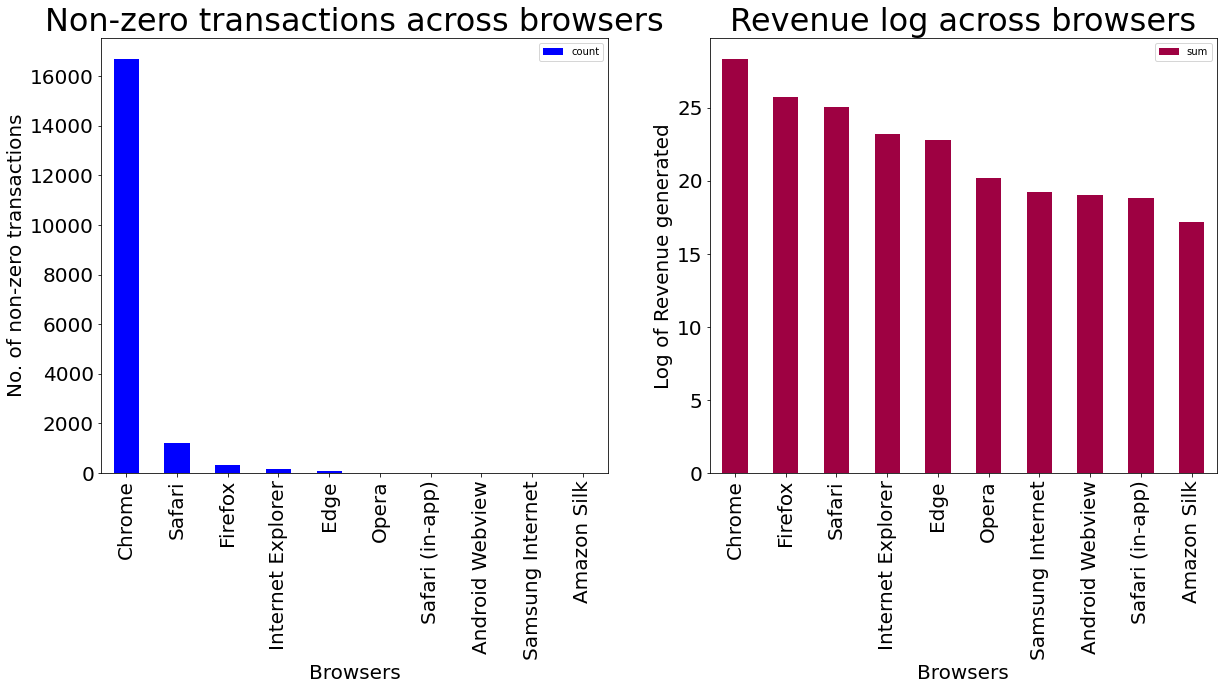

In [11]:
# creating a subplot grid of 1 x 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

# ------no of user visits across each browser------
# grouping by browsers according to each customer
tmp = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['count','sum']).reset_index()
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('count', ascending=False).head(10).plot(kind='bar', x='device.browser', y='count', \
                                                        colormap='winter', ax=axes[0], \
                                                        title = 'Non-zero transactions across browsers')
axes[0].set_xlabel("Browsers", fontsize=20)
axes[0].set_ylabel("No. of non-zero transactions", fontsize=20)

# ------log of revenue generated by each browser-------
tmp['sum'] = np.log1p(tmp['sum'])
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('sum', ascending=False).head(10).plot(kind='bar', x='device.browser', y='sum', \
                                                       title="Revenue log across browsers", 
                                                       colormap='Spectral', ax=axes[1])
axes[1].set_xlabel("Browsers", fontsize=20)
axes[1].set_ylabel("Log of Revenue generated", fontsize=20)

plt.show()

In [16]:
print(np.expm1(tmp[tmp['device.browser'] == 'Amazon Silk']['sum']))
tmp[tmp['device.browser'] == 'Amazon Silk']

24    29990000.0
Name: sum, dtype: float64


,device.browser,count,sum
24,Amazon Silk,1,17.216375


* **Observations:**
    1. No of visits and revenue generated is highest from Chrome.
    2. Marketing teams can focus on chrome users to maximise the revenue generation.

## 2.7 City analysis

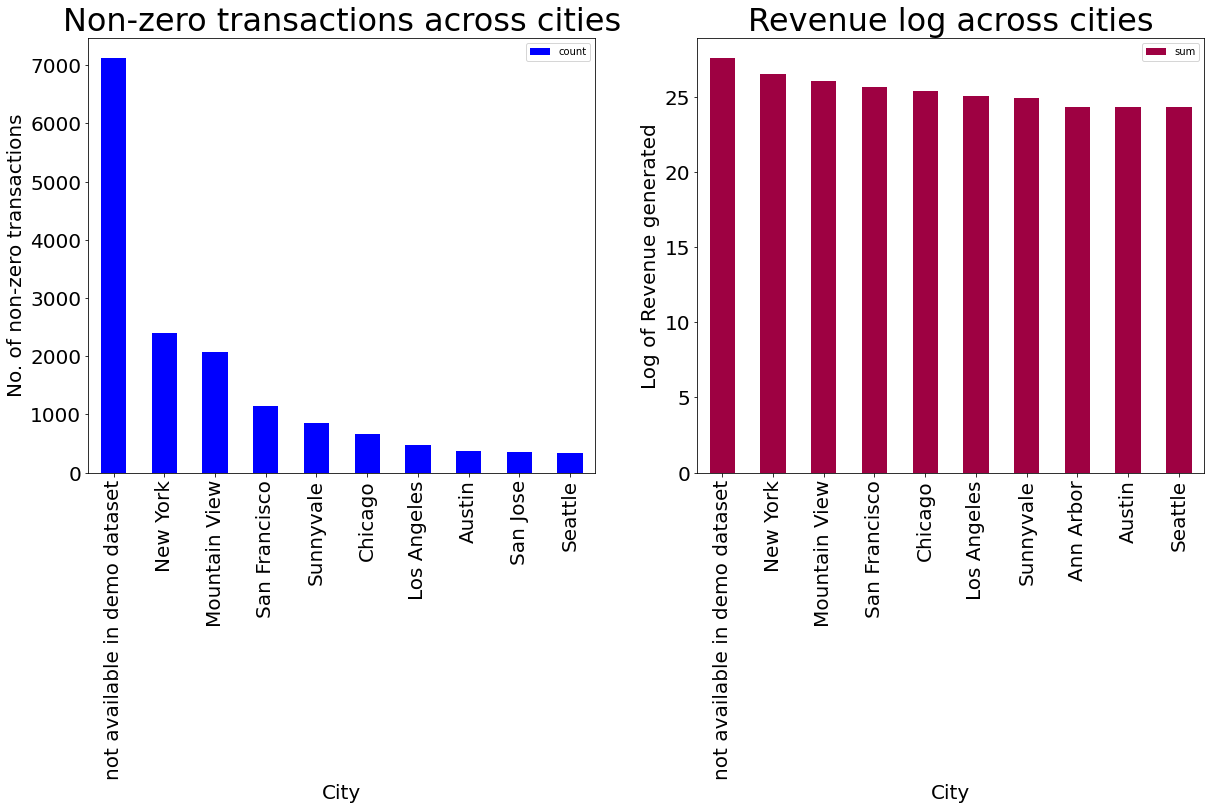

In [17]:
# creating a subplot grid of 1 x 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

# ------no of user visits across each city------
# grouping by city according to each customer
tmp = train_df.groupby('geoNetwork.city')['totals.transactionRevenue'].agg(['sum', 'count']).reset_index()
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('count', ascending=False).head(10).plot(kind='bar', x='geoNetwork.city', \
                                                        y='count', colormap='winter', ax=axes[0], \
                                                        title = 'Non-zero transactions across cities')
axes[0].set_xlabel("City", fontsize=20)
axes[0].set_ylabel("No. of non-zero transactions", fontsize=20)

# ------revenue generated by each city-------
tmp['sum'] = np.log1p(tmp['sum'])
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('sum', ascending=False).head(10).plot(kind='bar', x='geoNetwork.city', y='sum', \
                                                      title="Revenue log across cities", \
                                                      colormap='Spectral', ax=axes[1])
axes[1].set_xlabel("City", fontsize=20)
axes[1].set_ylabel("Log of Revenue generated", fontsize=20)

plt.show()

* **Observations:**
    1. American users visits the store most and also generate the most revenue.
    2. Asian and European users visits the store less compared to American users but still generate good chunk of revenue.

# multivariate

## numeric

In [101]:
multi_num.columns

Index(['totals.pageviews', 'totals.timeOnSite', 'sum'], dtype='object')

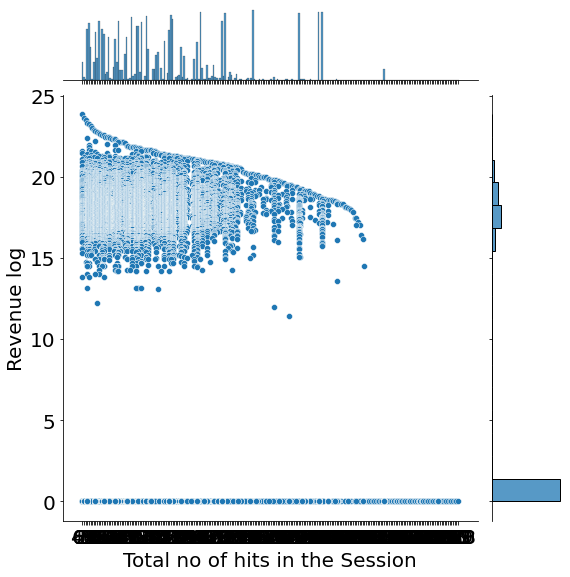

In [20]:
multi_num = train_df.groupby(['totals.pageviews', 'totals.timeOnSite'])['totals.transactionRevenue'].agg(['sum'])\
                                                .sort_values('sum', ascending=False).reset_index()
# multi_num
multi_num['sum'] = multi_num['sum'].apply(lambda x: np.log1p(x))
multi_num.columns = ['grp1','grp2', 'revenue_log']
jplot = sns.jointplot(x='grp1', y='revenue_log', data=multi_num, height=8, dropna=True)
jplot.set_axis_labels('Total no of hits in the Session', 'Revenue log', fontsize=20)
plt.show()

## categorical

In [7]:
multi_analysis = train_df.groupby(['device.browser', 'device.operatingSystem'])['totals.transactionRevenue'].agg(['sum', 'count']).sort_values('sum', ascending=False)#.reset_index()
multi_analysis['sum'] = multi_analysis['sum'].apply(lambda x: np.log1p(x))
print(multi_analysis.columns)
multi_analysis

Index(['sum', 'count'], dtype='object')


sum  count
device.browser             device.operatingSystem                  
Chrome                     Macintosh               27.862134   9735
                           Windows                 26.749772   3109
                           Chrome OS               26.320399   1703
Firefox                    Windows                 25.666728    229
Chrome                     Linux                   24.946798   1285
...                                                      ...    ...
LYF_LS_4002_12             (not set)                0.000000      0
Lunascape                  Windows                  0.000000      0
                           iOS                      0.000000      0
M5                         Android                  0.000000      0
zurcqesbhljxmpwdgnvkoyafit (not set)                0.000000      0

[214 rows x 2 columns]

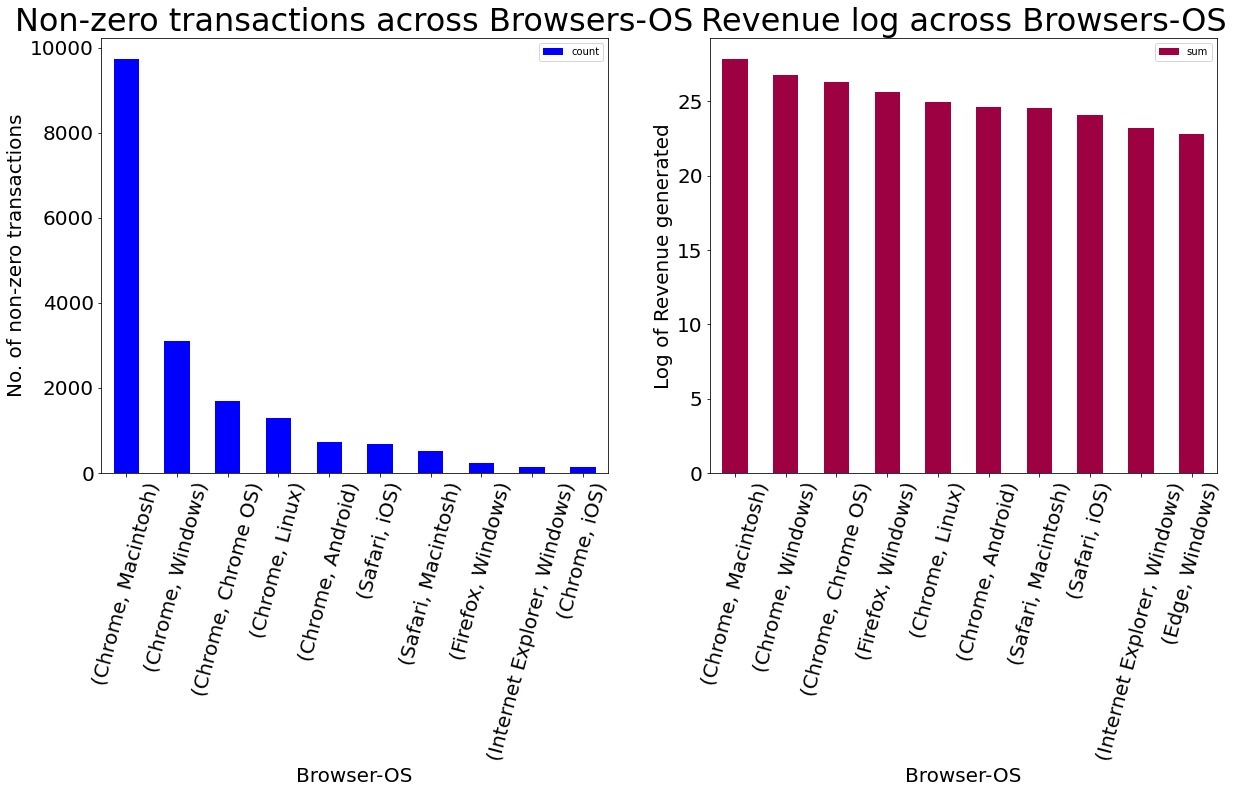

In [12]:
# creating a subplot grid of 1 x 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

# ------no of user visits across Browser-OS groups------
# grouping by Browser-OS
tmp = train_df.groupby(['device.browser', 'device.operatingSystem'])['totals.transactionRevenue'].agg(['sum', 'count']).sort_values('sum', ascending=False)
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('count', ascending=False).head(10).plot(kind='bar',  \
                                                        y='count', colormap='winter', ax=axes[0], \
                                                        title = 'Non-zero transactions across Browsers-OS', rot=75)
axes[0].set_xlabel("Browser-OS", fontsize=20)
axes[0].set_ylabel("No. of non-zero transactions", fontsize=20)

# ------revenue generated by each city-------
tmp['sum'] = np.log1p(tmp['sum'])
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('sum', ascending=False).head(10).plot(kind='bar',  y='sum', \
                                                      title="Revenue log across Browsers-OS", \
                                                      colormap='Spectral', ax=axes[1], rot=75)
axes[1].set_xlabel("Browser-OS", fontsize=20)
axes[1].set_ylabel("Log of Revenue generated", fontsize=20)

plt.show()

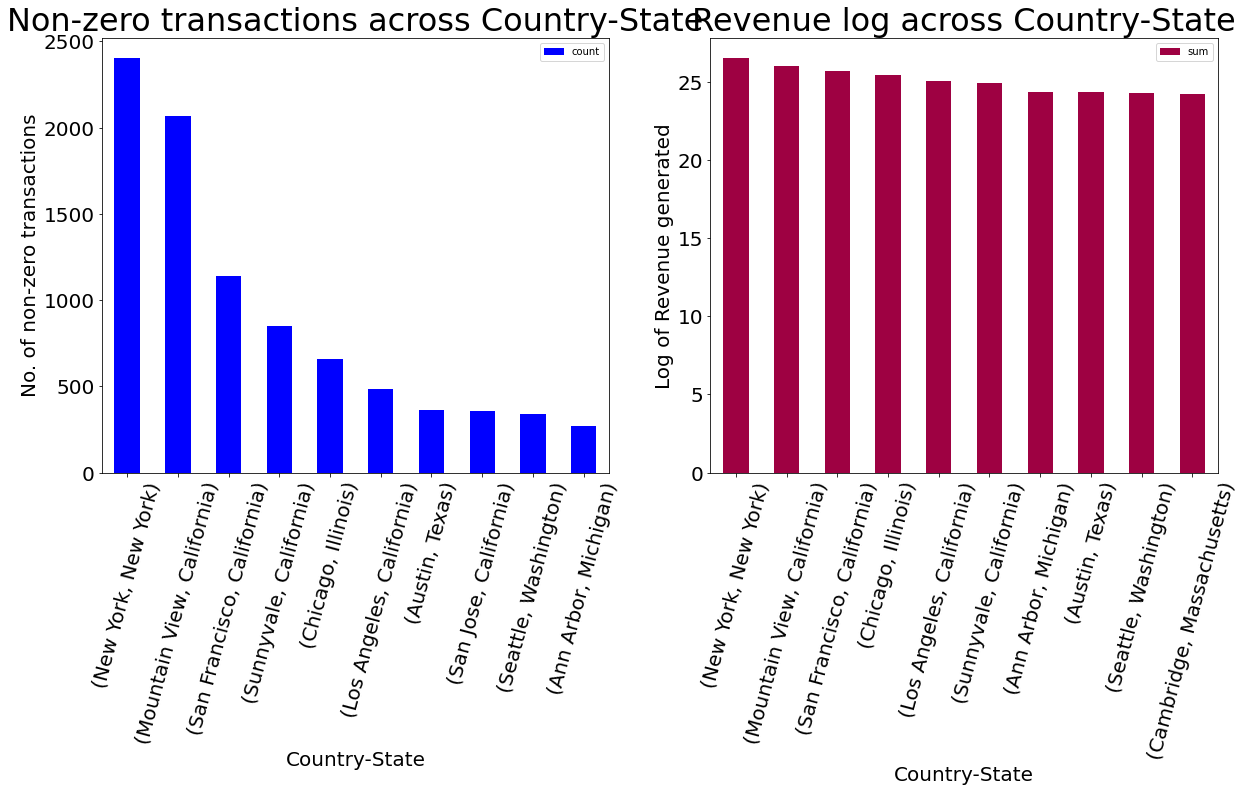

In [22]:
# multi_analysis = train_df.groupby(['geoNetwork.region', 'geoNetwork.country'])['totals.transactionRevenue'].agg(['sum']).sort_values('sum', ascending=False)#.reset_index()
# creating a subplot grid of 1 x 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

# ------no of user visits across each city------
# grouping by city according to each customer
tmp = train_df.groupby(['geoNetwork.city','geoNetwork.region'])['totals.transactionRevenue'].agg(['sum', 'count']).sort_values('sum', ascending=False)
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('count', ascending=False)[1:11].plot(kind='bar',  \
                                                        y='count', colormap='winter', ax=axes[0], \
                                                        title = 'Non-zero transactions across Country-State', rot=75)
axes[0].set_xlabel("Country-State", fontsize=20)
axes[0].set_ylabel("No. of non-zero transactions", fontsize=20)

# ------revenue generated by each city-------
tmp['sum'] = np.log1p(tmp['sum'])
# plotting the bar graph
# selecting top 10 entires using head(10)
tmp.sort_values('sum', ascending=False)[1:11].plot(kind='bar',  y='sum', \
                                                      title="Revenue log across Country-State", \
                                                      colormap='Spectral', ax=axes[1], rot=75)
axes[1].set_xlabel("Country-State", fontsize=20)
axes[1].set_ylabel("Log of Revenue generated", fontsize=20)

plt.show()

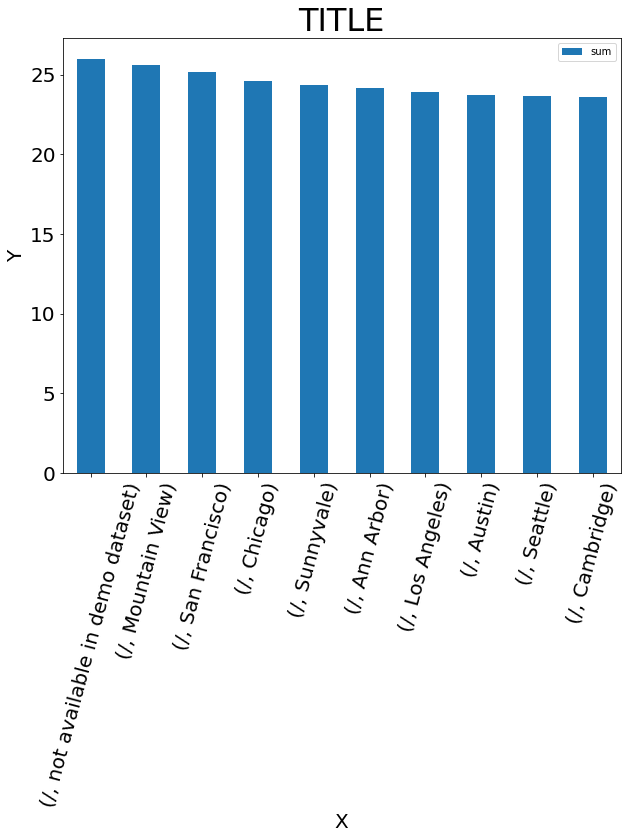

In [111]:
multi_analysis = train_df.groupby(['trafficSource.referralPath', 'geoNetwork.city'])['totals.transactionRevenue'].agg(['sum']).sort_values('sum', ascending=False)#.reset_index()
multi_analysis['sum'] = multi_analysis['sum'].apply(lambda x: np.log1p(x))

mplot = multi_analysis[1:11].sort_values('sum', ascending=False).plot.bar(stacked=True, title='TITLE',figsize=(10,8), rot=75);
mplot.set_xlabel("X", fontsize=20)
mplot.set_ylabel("Y", fontsize=20);

In [30]:
train_df.dtypes

channelGrouping                                 object
customDimensions                                object
date                                             int64
fullVisitorId                                   object
hits                                            object
visitId                                          int64
visitNumber                                      int64
visitStartTime                                   int64
device.browser                                  object
device.operatingSystem                          object
device.isMobile                                   bool
device.deviceCategory                           object
geoNetwork.continent                            object
geoNetwork.subContinent                         object
geoNetwork.country                              object
geoNetwork.region                               object
geoNetwork.metro                                object
geoNetwork.city                                 object
geoNetwork

In [15]:
train_df['totals.hits'] = train_df['totals.hits'].astype('int32')
train_df['totals.pageviews'] = train_df['totals.pageviews'].astype('int32')

In [17]:
train_subset.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'visitId', 'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions',
       'totals.transactionRevenue', 'totals.totalTransactionRevenue',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType'],
      dtype='object')

In [25]:
train_subset['totals.transactionRevenue'] = train_subset['totals.transactionRevenue'].astype('int64')
train_subset.dtypes

channelGrouping                                 object
customDimensions                                object
date                                             int64
fullVisitorId                                   object
hits                                            object
visitId                                          int64
visitNumber                                      int64
visitStartTime                                   int64
device.browser                                  object
device.operatingSystem                          object
device.isMobile                                   bool
device.deviceCategory                           object
geoNetwork.continent                            object
geoNetwork.subContinent                         object
geoNetwork.country                              object
geoNetwork.region                               object
geoNetwork.metro                                object
geoNetwork.city                                 object
geoNetwork

In [58]:
multi_analysis = train_subset.groupby(['device.browser', 'device.operatingSystem'])['totals.transactionRevenue'].agg(['sum'])#.reset_index()
multi_analysis['sum'] = multi_analysis['sum'].apply(lambda x: np.log1p(x))
multi_analysis

sum
device.browser    device.operatingSystem           
Android Webview   Android                  0.000000
Chrome            Android                  0.000000
                  Chrome OS               18.089813
                  Linux                    0.000000
                  Macintosh               20.171375
                  Windows                 20.627228
                  iOS                      0.000000
Edge              Windows                  0.000000
Firefox           Linux                    0.000000
                  Macintosh                0.000000
                  Windows                  0.000000
Internet Explorer Windows                 17.553180
                  Windows Phone            0.000000
Opera             Android                  0.000000
Opera Mini        (not set)                0.000000
                  Android                  0.000000
Safari            Macintosh                0.000000
                  iOS                     17.863811
Safari (in-app)   iOS                      0.000000
Samsung Internet  Android                  0.000000
UC Browser        Android                  0.000000

<AxesSubplot:xlabel='device.browser,device.operatingSystem'>

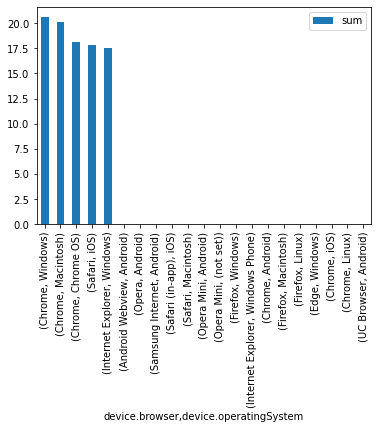

In [59]:
multi_analysis.sort_values('sum', ascending=False).plot.bar(stacked=True)

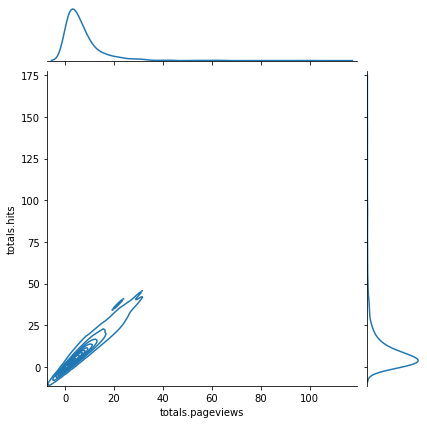

In [16]:
train_subset = train_df[:1000].copy(deep=True)
sns.jointplot(x='totals.pageviews', y='totals.hits', data=train_subset, kind='kde')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


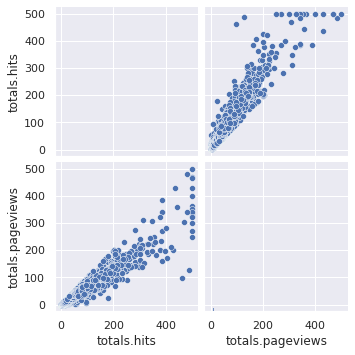

In [32]:
sns.set()
cols = ['totals.hits', 'totals.pageviews']#['device.browser', 'channelGrouping', 'device.operatingSystem']
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

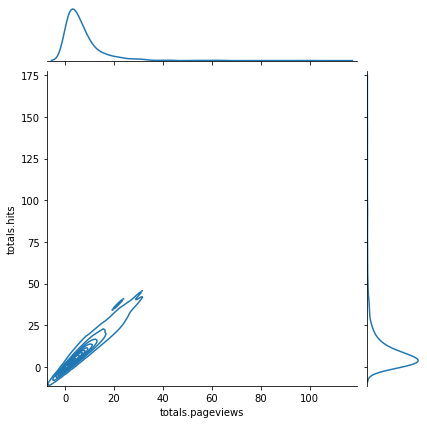

In [16]:
train_subset = train_df[:1000].copy(deep=True)
sns.jointplot(x='totals.pageviews', y='totals.hits', data=train_subset, kind='kde')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


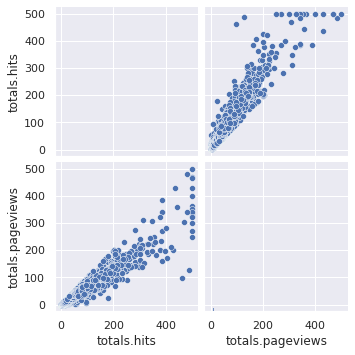

In [32]:
sns.set()
cols = ['totals.hits', 'totals.pageviews']#['device.browser', 'channelGrouping', 'device.operatingSystem']
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

# 3. Data Imputation

In [56]:
train_df.shape

(1708337, 36)

In [55]:
train_subset.head(2)

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,(not set),google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN


In [3]:
def missing_values(dataframe):
    ''' Calculates the no of missing values and their percentage for each column of the given dataframe and 
    displays it in a dataframe format.'''
    
    # isnull() : finding the missing values 
    # sum()    : taking the sum across all rows 
    # sort_values(ascending = False) : sorting in descending order
    total = dataframe.isnull().sum().sort_values(ascending = False) # total is the number of rows missing
    
    # percentage of missing values
    missing_values_series = total / len(dataframe) * 100
    # creating a dataframe to save this information
    missing_values_df = pd.concat([total, missing_values_series], axis=1, keys=['no of rows missing', 'percentage of data missing'])
    # display only columns having the missing values
    display(missing_values_df[missing_values_df['no of rows missing']!=0])
    

In [138]:
%%time
missing_values(train_df)

,no of rows missing,percentage of data missing
totals.transactionRevenue,1689823,98.916256
totals.totalTransactionRevenue,1689823,98.916256
totals.transactions,1689778,98.913622
trafficSource.adContent,1643600,96.210525
trafficSource.adwordsClickInfo.adNetworkType,1633063,95.593727
trafficSource.adwordsClickInfo.slot,1633063,95.593727
trafficSource.adwordsClickInfo.page,1633063,95.593727
trafficSource.adwordsClickInfo.gclId,1632914,95.585005
trafficSource.referralPath,1142073,66.852910
trafficSource.keyword,1052780,61.626014


CPU times: user 2.81 s, sys: 506 ms, total: 3.31 s
Wall time: 3.31 s


### Imputing the missing values 

* **totals.transactionRevenue:** Revenue generated in a session

In [173]:
%%time
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.transactionRevenue'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.transactionRevenue'].fillna(0, inplace=True)
test_df['totals.transactionRevenue'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.transactionRevenue'].isnull().sum()}")

Count of nan values:-
Before Imputation:1689823
After Imputation:0
CPU times: user 261 ms, sys: 12 ms, total: 273 ms
Wall time: 271 ms


*  **totals.totalTransactionRevenue:** Total revenue generated in a session

In [174]:
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.totalTransactionRevenue'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.totalTransactionRevenue'].fillna(0, inplace=True)
test_df['totals.totalTransactionRevenue'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.totalTransactionRevenue'].isnull().sum()}")

Count of nan values:-
Before Imputation:1689823
After Imputation:0


***
### Note:-
1. There seems to be some confusion regarding 'totals.totalTransactionRevenue' and 'totals.transactionRevenue' columns(source: https://www.kaggle.com/c/ga-customer-revenue-prediction/data).
2. The final conclusion from kaggle was that the target variable will be 'totals.transactionRevenue'.
***

* **totals.transactions:** No of transactions in a session

In [178]:
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.transactions'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.transactions'].fillna(0, inplace=True)
test_df['totals.transactions'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.transactions'].isnull().sum()}")

Count of nan values:-
Before Imputation:1689778
After Imputation:0


* **trafficSource.adContent:** The ad content of the traffic source.
    * This is a categorical feature. All missing values will be treated as a separate category.

In [182]:
train_df['trafficSource.adContent'].unique()

array([nan, 'Placement Accessories 300 x 250', 'Google Merchandise Store',
       'Bags 300x250', 'Display Ad created 3/11/14',
       'Placement Office 300x250', 'Placement Drinkware 300x250',
       'Office Placement 160x600', 'Bags 336x280',
       'test_tyler_hr_merchant', 'Drinkware 336x280',
       'Official Google Merchandise', 'First Full Auto Template Test Ad',
       'Full auto ad IMAGE ONLY', '{KeyWord:Google Brand Items}',
       'Ad from 11/7/16', 'Display Ad created 3/11/15', 'Ad from 11/3/16',
       'Ad from 12/13/16', 'Google Online Store',
       'Google Merchandise Collection', 'Display Ad created 11/17/14',
       '{KeyWord:Want Google Stickers?}', '{KeyWord:Google Merchandise}',
       '{KeyWord:Google Drinkware}', "{KeyWord:Google Men's T-Shirts}",
       '{KeyWord:Google Branded Gear}',
       '{KeyWord:Google Branded Apparel}', 'Smart display ad - 8/17/2017',
       'BQ', 'Placement Accessores 300 x 250',
       'Placement Accessories 336 x 280',
       'Placeme

* **trafficSource.adwordsClickInfo.adNetworkType:** Network Type of the traffic source.
    * This is a categorical feature. All missing values will be treated as a separate category.

In [183]:
train_df['trafficSource.adwordsClickInfo.adNetworkType'].unique()

array([nan, 'Google Search', 'Content', 'Search partners'], dtype=object)

* **trafficSource.adwordsClickInfo.slot:** Position of the Ad.
    * This is a categorical feature. All missing values will be treated as a separate category.

In [184]:
train_df['trafficSource.adwordsClickInfo.slot'].unique()

array([nan, 'Top', 'RHS', 'Google Display Network'], dtype=object)

# <font color='red'>TODO: Decide how to use this feature
* **trafficSource.adwordsClickInfo.page:** Page number in search results where the ad was shown.

In [185]:
train_df['trafficSource.adwordsClickInfo.page'].unique()

array([nan, '1', '3', '2', '5', '6', '4', '14', '7', '8', '9', '12'],
      dtype=object)

* **trafficSource.adwordsClickInfo.gclId:** The Google Click ID.
    * Google Click ID (GCLID) is a parameter passed in the URL with ad clicks, to identify the campaign and other attributes of the click associated with the ad for ad tracking and campaign attribution.
    * We can drop this feature because its 95% data is missing and it doesn't have much significance with the target variable.

In [188]:
train_df['trafficSource.adwordsClickInfo.gclId'].unique()

array([nan,
       'Cj0KCQjwsZHPBRClARIsAC-VMPBHdNF2oMOgh6Xp6YhjXWSk11sDu3eCo4De_u6l4xafqgrPVPSGYdkaArkiEALw_wcB',
       'CODVoMjJ9tYCFUIvgQod_dsKEA', ...,
       'CjwKEAiA17LDBRDElqOGq8vR7m8SJAA1AC0_F8I700U-81N2_1WVZF0O31tFIIq0ZrkCf2QJTXTgHRoCaxXw_wcB',
       'CjwKEAiA17LDBRDElqOGq8vR7m8SJAA1AC0_HT9qtS8geJzhbHcNi9P0HfV_VqljevGJkARlqcV0GxoCkbPw_wcB',
       'CjwKEAiA17LDBRDElqOGq8vR7m8SJAA1AC0_0wzbDX0fd-gzNVm4iuZRBFQ6id5RBK7XQZGOS1kIHRoCXJPw_wcB'],
      dtype=object)

* **trafficSource.referralPath:** If trafficSource.medium is "referral", then this is set to the path of the referrer.
    * This is a categorical feature. All missing values will be treated as a separate category.

In [191]:
train_df['trafficSource.referralPath'].unique()

array([nan,
       '/a/google.com/transportation/mtv-services/bikes/bike2workmay2016',
       '/offer/2145', ..., '/mail/mu/mp/118/', '/BB1QfReObs',
       '/mail/mu/mp/509/'], dtype=object)

# <font color='red'> TODO: Decide how to use this feature
* **trafficSource.keyword:** The keyword of the traffic source, usually set when the trafficSource.medium is "organic" or "cpc".

In [24]:
train_df['trafficSource.keyword'].nunique()

4546

In [23]:
train_df['trafficSource.keyword'].unique().tolist()

['water bottle',
 nan,
 '(not provided)',
 '(Remarketing/Content targeting)',
 '6qEhsCssdK0z36ri',
 '(automatic matching)',
 'Google men',
 '1hZbAqLCbjwfgOH7',
 '1X4Me6ZKNV0zg-jV',
 'google online merchandise',
 'google water bottle',
 '(User vertical targeting)',
 'google company store',
 'https://www.googlemerchandisestore.com/',
 'letterman jacket ebay',
 'google canada',
 'Google where is gabika clothing',
 'google online shops',
 'google Merchandising kosten',
 'www.google.com bag',
 'youtube youtube',
 'youtube www youtube com',
 'merchdise',
 'yputube',
 'youtube',
 'www you tope',
 'youtubeshop',
 'googel store',
 'google shirts buy',
 'Google mens',
 'shirt t shirt',
 'www google store',
 'google + online',
 'Google store',
 'buy google souvenirs',
 'shop shirts',
 'google t shirt',
 '+google +store',
 'google t-shirt',
 'hood pink',
 'youtube player t shirt',
 'https://www.googlemerchandisestore.com/shop.axd/Home',
 'android clothes',
 'store merchandise',
 'google store',
 '

* **totals.timeOnSite:** Total time of the session expressed in seconds.
    * Impute nan with 0.

In [28]:
train_df['totals.timeOnSite'].unique()

[nan,
 '28',
 '38',
 '1',
 '52',
 '12',
 '9',
 '15',
 '34',
 '32',
 '54',
 '11',
 '51',
 '111',
 '1266',
 '73',
 '49',
 '27',
 '62',
 '19',
 '29',
 '26',
 '148',
 '17',
 '31',
 '33',
 '30',
 '8',
 '571',
 '105',
 '97',
 '72',
 '47',
 '40',
 '14',
 '55',
 '22',
 '76',
 '156',
 '80',
 '89',
 '158',
 '24',
 '45',
 '53',
 '64',
 '35',
 '18',
 '116',
 '21',
 '20',
 '57',
 '96',
 '83',
 '4',
 '25',
 '61',
 '13',
 '37',
 '36',
 '1828',
 '48',
 '845',
 '124',
 '87',
 '91',
 '60',
 '43',
 '69',
 '189',
 '881',
 '42',
 '214',
 '66',
 '50',
 '218',
 '59',
 '46',
 '23',
 '77',
 '361',
 '164',
 '315',
 '106',
 '44',
 '242',
 '63',
 '100',
 '67',
 '2074',
 '90',
 '484',
 '78',
 '39',
 '496',
 '288',
 '41',
 '194',
 '129',
 '101',
 '1619',
 '159',
 '1801',
 '114',
 '915',
 '739',
 '898',
 '132',
 '65',
 '200',
 '79',
 '75',
 '56',
 '120',
 '1759',
 '137',
 '58',
 '139',
 '130',
 '259',
 '191',
 '122',
 '84',
 '150',
 '81',
 '102',
 '141',
 '109',
 '128',
 '754',
 '371',
 '401',
 '92',
 '819',
 '359',

In [29]:
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.timeOnSite'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.timeOnSite'].fillna(0, inplace=True)
test_df['totals.timeOnSite'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.timeOnSite'].isnull().sum()}")

Count of nan values:-
Before Imputation:874294
After Imputation:0


* **totals.sessionQualityDim:** An estimate of how close a particular session was to transacting, ranging from 1 to 100, calculated for each session. A value closer to 1 indicates a low session quality, or far from transacting, while a value closer to 100 indicates a high session quality, or very close to transacting.
    * A value of 0 indicates that Session Quality is not calculated for the selected time range. So we will impute nan with 0.

In [194]:
train_df['totals.sessionQualityDim'].unique()

array(['1', '2', '3', '4', '6', '8', '5', '7', '11', '13', '9', '10',
       '49', '52', '22', '54', '31', '28', '60', '35', '30', '32', '41',
       '19', '25', '15', '24', '62', '12', '14', '17', '38', '63', '16',
       '23', '42', '21', '18', '48', '40', '73', '53', '61', '36', '67',
       '47', '72', '77', '58', '45', '26', '75', '68', '59', '43', '80',
       '46', '74', '76', '66', '81', '82', '70', '27', '56', '50', '88',
       '39', '44', '85', '55', '79', '64', '93', '83', '78', '86', '65',
       '69', '84', '71', '51', nan, '34', '20', '57', '37', '29', '90',
       '87', '92', '91', '96', '33', '89', '94', '95', '97', '99', '98',
       '100'], dtype=object)

In [30]:
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.sessionQualityDim'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.sessionQualityDim'].fillna(0, inplace=True)
test_df['totals.sessionQualityDim'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.sessionQualityDim'].isnull().sum()}")

Count of nan values:-
Before Imputation:835274
After Imputation:0


* **totals.pageviews:** Total number of pageviews within the session.
    * Only 1% of pageview data is missing. We will impute nan with 0.

In [31]:
train_df['totals.pageviews'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '20', '19', '21', '23', '22',
       '26', '28', '25', '31', '27', '24', '29', '30', '32', '33', '42',
       '38', '53', '40', '62', '61', '54', '60', '111', '98', '34', '35',
       '36', '37', '39', '43', '45', '47', '52', '44', '50', '49', '46',
       '51', '56', '59', '71', '57', '82', '84', '92', '90', '68', '115',
       nan, '41', '79', '138', '48', '69', '112', '65', '63', '58', '74',
       '165', '100', '85', '55', '70', '80', '78', '72', '188', '73',
       '75', '86', '197', '76', '67', '102', '148', '64', '103', '144',
       '81', '119', '66', '104', '128', '230', '87', '152', '101', '94',
       '83', '135', '91', '99', '118', '107', '140', '108', '77', '202',
       '127', '93', '106', '155', '117', '89', '143', '105', '95', '110',
       '137', '125', '120', '116', '208', '126', '400', '333', '97', '96',
       '113', '327', '154', '121', '183', '123', '14

In [32]:
print('Count of nan values:-')
print(f"Before Imputation:{train_df['totals.pageviews'].isnull().sum()}")
# we will impute 'nan' with 0
train_df['totals.pageviews'].fillna(0, inplace=True)
test_df['totals.pageviews'].fillna(0, inplace=True)
print(f"After Imputation:{train_df['totals.pageviews'].isnull().sum()}")

Count of nan values:-
Before Imputation:239
After Imputation:0


* Making sure there is no missing data for numerical columns. Categorical missing values will be handled with label encoding them as other category

In [38]:
missing_values(train_df)

,no of rows missing,percentage of data missing
trafficSource.adContent,1643600,96.210525
trafficSource.adwordsClickInfo.adNetworkType,1633063,95.593727
trafficSource.adwordsClickInfo.slot,1633063,95.593727
trafficSource.adwordsClickInfo.page,1633063,95.593727
trafficSource.adwordsClickInfo.gclId,1632914,95.585005
trafficSource.referralPath,1142073,66.852910
trafficSource.keyword,1052780,61.626014


## pickle imputed df

In [36]:
# %%time
# with open('test_df_imputed.pickle','wb') as f:
#     pickle.dump(test_df, f)
# with open('train_df_imputed.pickle','wb') as f:
#     pickle.dump(train_df, f)

CPU times: user 49.9 s, sys: 1min 7s, total: 1min 56s
Wall time: 4min 22s


## read imputed df

In [5]:
%%time
with open('test_df_imputed.pickle','rb') as f:
    test_df = pickle.load(f)
with open('train_df_imputed.pickle','rb') as f:
    train_df = pickle.load(f)

CPU times: user 21.3 s, sys: 45.1 s, total: 1min 6s
Wall time: 5min 4s


# 3. Feature Engineering

In [214]:
train_df.dtypes

channelGrouping                                         object
customDimensions                                        object
date                                            datetime64[ns]
fullVisitorId                                           object
hits                                                    object
visitId                                                  int64
visitNumber                                              int64
visitStartTime                                           int64
device.browser                                          object
device.operatingSystem                                  object
device.isMobile                                           bool
device.deviceCategory                                   object
geoNetwork.continent                                    object
geoNetwork.subContinent                                 object
geoNetwork.country                                      object
geoNetwork.region                                      

In [251]:
# changing dtypes
# Numerical features:-
numeric_cols = ['visitNumber','visitStartTime','totals.hits','totals.pageviews',\
                'totals.timeOnSite','totals.transactions','totals.transactionRevenue']

for col in numeric_cols:
    train_df[col] = train_df[col].astype('float')    
    test_df[col] = test_df[col].astype('float')
    print(f'{col} converted to float')

visitNumber converted to float
visitStartTime converted to float
totals.hits converted to float
totals.pageviews converted to float
totals.timeOnSite converted to float
totals.transactions converted to float
totals.transactionRevenue converted to float


# <font color='red'> TODO: FINALISE CATEGORICAL FEATURES

In [ ]:
# Categorical features:-
# **********full list pending***************
cat_cols = ['channelGrouping','device.browser','device.operatingSystem','device.deviceCategory',\
'geoNetwork.continent','geoNetwork.subContinent','geoNetwork.country','trafficSource.source']

for col in cat_cols:
    
    # intitalizing label encoder object
    label_encoder = preprocessing.LabelEncoder() 
    # train label encoder using train and test features
    label_encoder.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
                                                             
    # transforming features using the label encoder object
    train_df[feature] = label_encoder.transform(list(train_df[feature].values.astype('str'))) 
    test_df[feature]  = label_encoder.transform(list(test_df[feature].values.astype('str')))
    
    

In [252]:
train_df.dtypes

channelGrouping                                         object
customDimensions                                        object
date                                            datetime64[ns]
fullVisitorId                                           object
hits                                                    object
visitId                                                  int64
visitNumber                                            float64
visitStartTime                                         float64
device.browser                                          object
device.operatingSystem                                  object
device.isMobile                                           bool
device.deviceCategory                                   object
geoNetwork.continent                                    object
geoNetwork.subContinent                                 object
geoNetwork.country                                      object
geoNetwork.region                                      